# STAT778: Final Project

In [1]:
import numpy as np
from numpy.random import uniform, normal, multivariate_normal, exponential
import scipy as sc
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#it's not quite this. 3.2 does some sort of learning. how?
#we're measuring the likelihood (via the pdf) of x given our parameters and the result.
#THEN we combine that with our prior.
#Then we have a posterior belief about how possible these parameters are given the data we just saw and our prior belief.
#now we binarize this belief stochastically! and move onto the next iteration.

## Metropolis-Hastings with a Bayesian Linear Model

In [251]:
#metropolis-hastings functions
def sample(data: np.ndarray, N: int, B: int, start_theta: tuple, search_breadth: float=0.5):
    """Takes N samples via the Metropolis-Hastings algorithm, with B burn-in samples."""
    theta = start_theta
    for b in range(B): #burnin samples
        results = step(data, theta, search_breadth)
        theta = results['theta']
    
    samples = []
    for n in range(N): #real samples
        results = step(data, theta, search_breadth)
        theta = results['theta']
        samples.append(results)
    return samples

def step(data: np.ndarray, theta: tuple, search_breadth: float):
    """Takes one step in the Metropolis-Hastings algorithm by generating a new theta and comparing to a given theta."""
    theta_prime = sample_theta(theta, search_breadth) #sample a new set of parameters
    print(f"sampled theta_prime as: {theta_prime}")
    acceptance_log_prob = calc_acceptance_prob(theta, theta_prime, data, search_breadth) #calculate the probability of acceptance
    accepted = np.exp(acceptance_log_prob) >= uniform() #probabilistically determine acceptance 
    return {'accepted': accepted, 'acceptance_prob': np.exp(acceptance_log_prob), 'theta': theta_prime if accepted else theta} #return results, update theta if samples accepted

def sample_theta(theta: tuple, search_breadth: float=1):
    """Samples theta parameters--slope, intercept, and standard deviation."""
    a,b,sigma = theta
    a,b = multivariate_normal([a,b], [[search_breadth**2,0],[0,search_breadth**2]])
    sigma = exponential(sigma*search_breadth)
    theta = a,b,sigma
    return theta

def calc_acceptance_prob(theta: tuple, theta_prime: tuple, data: np.ndarray, search_breadth: float):
    """Calculates acceptance probability by using a Bayesian linear model."""
    theta_likelihood = likelihood(theta, data)
    theta_prior = prior(theta)
    print(f"theta likelihood: {theta_likelihood}\ttheta prior: {theta_prior}")
    
    theta_p_likelihood = likelihood(theta_prime, data)
    theta_p_prior = prior(theta_prime)
    print(f"theta prime likelihood: {theta_p_likelihood}\ttheta prime prior: {theta_p_prior}")
    
    
    pr = proposal_ratio(theta, theta_prime, search_breadth)
    acceptance_ratio = theta_p_likelihood - theta_likelihood + theta_p_prior - theta_prior + pr
    print(f"proposal ratio: {pr}")
    print(f"acceptance ratio: {acceptance_ratio}")
    return acceptance_ratio

#bayesian functions
def likelihood(theta: tuple, data: np.ndarray):
    """Calculates the likelihood component of our linear model by measuring our parameters theta on the given data."""
    a,b,sigma = theta
    x,y = data[0],data[1]
    likelihoods = sc.stats.norm.logpdf(y, loc=a*x+b, scale=sigma) #find the likelihood of a sample given a normal distribution specified by our parameters and the data
    return np.sum(likelihoods) #use log likelihood for stability

def prior(theta):
    """Calculates the prior component of our linear model, specified """
    a,b,sigma = theta
    a_prob, b_prob = sc.stats.multivariate_normal.logpdf([a,b]) #cov defaults to 1
    sigma_prob = sc.stats.expon.logpdf(sigma)
    return np.sum([a_prob,b_prob,sigma_prob])

def proposal_ratio(theta: tuple, theta_prime: tuple, search_breadth: float):
    """Offsets bidirectionality of chained samples."""
    a,b,sigma = theta
    a_p,b_p,sigma_p = theta_prime
    old_given_new_ab = sc.stats.multivariate_normal.logpdf([a,b],[a_p,b_p],[[search_breadth**2,0],[0,search_breadth**2]])
    old_given_new_sigma = sc.stats.expon.logpdf(sigma, sigma_p, search_breadth)
    old_given_new = old_given_new_ab + old_given_new_sigma
    
    #new_given_old = sc.stats.multivariate_normal.logpdf([a_p,b_p],[a,b])+sc.stats.expon.logpdf(sigma_p)
    new_given_old_ab = sc.stats.multivariate_normal.logpdf([a_p,b_p],[a,b],[[search_breadth**2,0],[0,search_breadth**2]])
    new_given_old_sigma = sc.stats.expon.logpdf(sigma_p, sigma, search_breadth)
    new_given_old = new_given_old_ab - new_given_old_sigma
    
    print(f"ogn: {old_given_new}\tngo: {new_given_old}")
    return old_given_new - new_given_old

In [252]:
X = np.random.rand(10000)
Y = np.random.normal(4,2,10000)
data = np.vstack((X,Y))
step(data,(4,0,2),0.5)

sampled theta_prime as: (3.5147093770488924, 0.03477413287923185, 1.3042054663030305)
theta likelihood: -27752.538822625815	theta prior: -11.837877066409344
theta prime likelihood: -40891.554548405686	theta prime prior: -9.319278155428833
ogn: -1.6234570502070016	ngo: inf
proposal ratio: -inf
acceptance ratio: -inf


{'accepted': False, 'acceptance_prob': 0.0, 'theta': (4, 0, 2)}

In [167]:
proposal_ratio((0,0,1),(0,0,1),0.5)

0.0

In [162]:
search_breadth = 1
sigma,sigma_p = 0.9,0.9
sc.stats.expon.pdf(sigma, sigma_p, search_breadth)

1.0

In [145]:
sc.stats.expon.logpdf(1, 0.8, 0.5)

0.2931471805599454

In [141]:
sigma_p*search_breadth*500,1/(search_breadth*500)

(5000, 0.0002)

In [134]:
sc.stats.expon.logpdf(sigma, sigma_p*500, 1/(search_breadth*500))

-inf

In [124]:
a,b,a_p,b_p = 0,0,0,0
search_breadth = 1
sc.stats.multivariate_normal.logpdf([a,b],[a_p,b_p])

-1.8378770664093453

In [125]:
sc.stats.multivariate_normal.logpdf([a,b],[a_p,b_p],[[search_breadth**2,0],[0,search_breadth**2]])

-1.8378770664093453

In [114]:
proposal_ratio((0,0,1),(0,0,1))

-2.8378770664093453

now testing the functions

In [106]:
theta = (4,2,1)

In [107]:
sample_theta(theta)

(5.32163557524331, 3.2855013471251717, 0.34604251102767586)

In [108]:
X = np.random.rand(10000)
Y = np.random.normal(4,2,10000)
data = np.vstack((X,Y))
likelihood(theta, data)

-35945.70898246656

In [109]:
prior(theta)

-12.837877066409344

In [112]:
proposal_ratio((0,0,1),(0,1,1))

0.0

## Zero Case: N(0,1)

In [30]:
X = np.random.rand(10000)
Y = np.random.normal(0,1,10000)
data = np.vstack((X,Y))
samples = sample(data, 30000, 0, (0,0,1), 1)
df = pd.DataFrame(samples)
df[['a','b','sigma']] = pd.DataFrame(df['theta'].tolist(), index=df.index)
df = df.drop(['theta'], axis=1)

<ipython-input-29-270b72b21154>:39: RuntimeWarning: invalid value encountered in double_scalars
  acceptance_ratio = theta_p_likelihood / theta_likelihood * theta_p_prior / theta_prior * proposal_ratio(theta, theta_prime)
c:\users\seans\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\_continuous_distns.py:243: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\users\seans\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\_distn_infrastructure.py:1835: RuntimeWarning: overflow encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
c:\users\seans\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\_distn_infrastructure.py:1835: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


Text(0.5, 1.0, 'The Data')

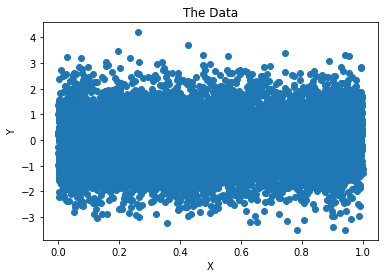

In [31]:
plt.scatter(X,Y)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("The Data")

In [32]:
df

,accepted,acceptance_prob,a,b,sigma
0,True,1,2.141490,0.660475,1.030313
1,True,1,1.659474,1.588487,0.765361
2,True,1,3.127941,2.183376,1.389618
3,True,1,2.110173,1.758830,0.204768
4,True,1,2.935851,3.778255,0.116450
...,...,...,...,...,...
29995,True,1,-390.882708,87.669942,0.000000
29996,True,1,-388.364193,89.483950,0.000000
29997,True,1,-389.157469,90.931026,0.000000
29998,True,1,-389.865923,91.069570,0.000000


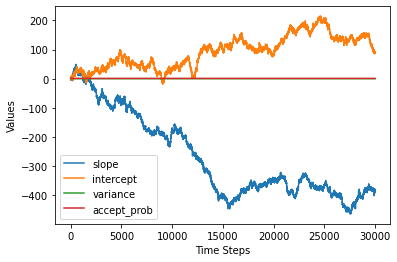

In [33]:
plt.plot(range(len(df)),df['a'], label='slope')
plt.plot(range(len(df)),df['b'], label='intercept')
plt.plot(range(len(df)),df['sigma'], label='variance')
plt.plot(range(len(df)),df['acceptance_prob'], label='accept_prob')
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()

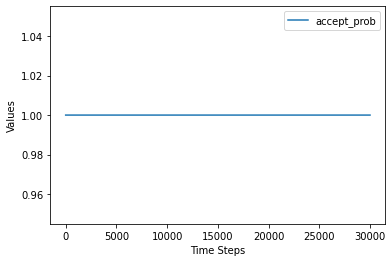

In [34]:
plt.plot(range(len(df)),df['acceptance_prob'], label='accept_prob')
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()

## Nonzero Case: N(4,2)

In [47]:
X = np.random.rand(10000)
Y = np.random.normal(4,2,10000)
data = np.vstack((X,Y))
samples = sample(data, 30000, 0, (0,0,1), 0.5)
df = pd.DataFrame(samples)
df[['a','b','sigma']] = pd.DataFrame(df['theta'].tolist(), index=df.index)
df = df.drop(['theta'], axis=1)

<ipython-input-29-270b72b21154>:39: RuntimeWarning: invalid value encountered in double_scalars
  acceptance_ratio = theta_p_likelihood / theta_likelihood * theta_p_prior / theta_prior * proposal_ratio(theta, theta_prime)
c:\users\seans\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\_continuous_distns.py:243: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\users\seans\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\_distn_infrastructure.py:1835: RuntimeWarning: overflow encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
c:\users\seans\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\_distn_infrastructure.py:1835: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


Text(0.5, 1.0, 'The Data')

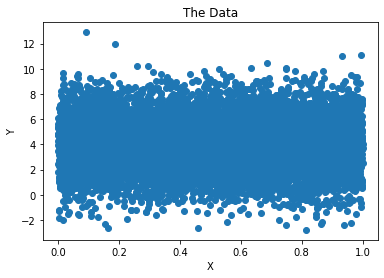

In [48]:
plt.scatter(X,Y)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("The Data")

In [49]:
df
#it accepts every single one?
#does it arrive to the right parameters?
#effect of changing starting point?

,accepted,acceptance_prob,a,b,sigma
0,True,1,-0.079643,0.157989,8.639905e-02
1,True,1,-0.160485,0.204024,6.811038e-04
2,True,1,-0.119418,0.188725,5.036022e-06
3,True,1,-0.153117,0.161941,1.983162e-07
4,True,1,-0.119642,0.146090,3.080873e-08
...,...,...,...,...,...
29995,True,1,-6.207670,8.778717,0.000000e+00
29996,True,1,-6.167303,8.767717,0.000000e+00
29997,True,1,-6.185147,8.693212,0.000000e+00
29998,True,1,-6.186158,8.782104,0.000000e+00


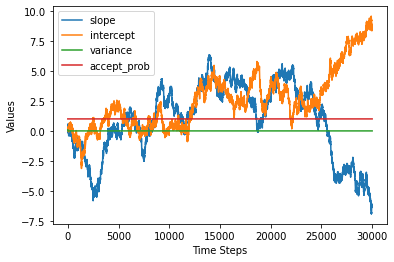

In [50]:
plt.plot(range(len(df)),df['a'], label='slope')
plt.plot(range(len(df)),df['b'], label='intercept')
plt.plot(range(len(df)),df['sigma'], label='variance')
plt.plot(range(len(df)),df['acceptance_prob'], label='accept_prob')
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()

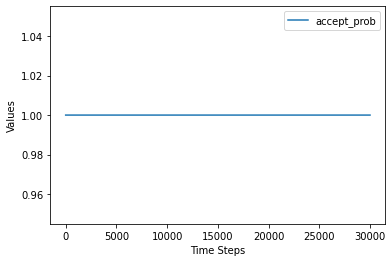

In [51]:
plt.plot(range(len(df)),df['acceptance_prob'], label='accept_prob')
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()

In [52]:
df.head(50)

,accepted,acceptance_prob,a,b,sigma
0,True,1,-0.079643,0.157989,8.639905e-02
1,True,1,-0.160485,0.204024,6.811038e-04
2,True,1,-0.119418,0.188725,5.036022e-06
3,True,1,-0.153117,0.161941,1.983162e-07
4,True,1,-0.119642,0.146090,3.080873e-08
5,True,1,-0.087926,0.185331,3.955072e-10
6,True,1,0.072829,0.190390,7.158080e-12
7,True,1,0.076807,0.284888,2.674381e-13
8,True,1,0.074618,0.223959,4.406620e-14
9,True,1,0.045821,0.218420,2.940932e-15


## The Larger Case: N(50, 5)

In [12]:
X = np.random.rand(100)
Y = np.random.normal(4,2,10000)
data = np.vstack((X,Y))
samples = sample(data, 30000, 0, (0,0,1), 1)
df = pd.DataFrame(samples)
df[['a','b','sigma']] = pd.DataFrame(df['theta'].tolist(), index=df.index)
df = df.drop(['theta'], axis=1)

<ipython-input-3-083a8b270b4d>:39: RuntimeWarning: divide by zero encountered in double_scalars
  acceptance_ratio = (theta_p_likelihood/theta_likelihood) * ((theta_p_prior/theta_prior) * proposal_ratio(theta, theta_prime))


In [13]:
df

,accepted,acceptance_prob,a,b,sigma
0,True,1.000000e+00,0.826128,0.965586,1.313404
1,False,0.000000e+00,0.826128,0.965586,1.313404
2,False,0.000000e+00,0.826128,0.965586,1.313404
3,True,1.000000e+00,1.245875,1.526074,1.378332
4,True,1.000000e+00,-0.114892,2.301349,2.289059
...,...,...,...,...,...
29995,False,0.000000e+00,1.735662,3.103275,1.789889
29996,False,1.338904e-38,1.735662,3.103275,1.789889
29997,False,2.177689e-30,1.735662,3.103275,1.789889
29998,False,5.329443e-192,1.735662,3.103275,1.789889


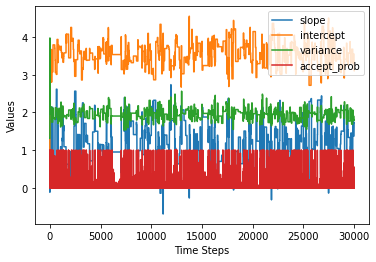

In [14]:
plt.plot(range(len(df)),df['a'], label='slope')
plt.plot(range(len(df)),df['b'], label='intercept')
plt.plot(range(len(df)),df['sigma'], label='variance')
plt.plot(range(len(df)),df['acceptance_prob'], label='accept_prob')
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()

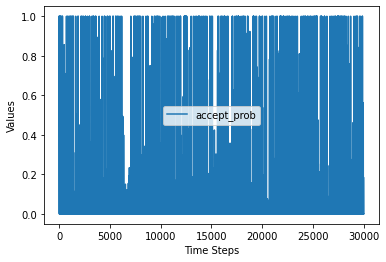

In [15]:
plt.plot(range(len(df)),df['acceptance_prob'], label='accept_prob')
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()